In [ ]:
# autoreload ext
%load_ext autoreload
%autoreload 2
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from stable_diffusion_xl_partedit import PartEditPipeline, DotDictExtra, Binarization, PaddingStrategy
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, ToPILImage

In [ ]:
device = torch.device(f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu")
sd_pipe, pipe = PartEditPipeline.default_pipeline(device, scheduler_type='ddim')
# pipe.set_progress_bar_config(disable=True)
# print(pipe.available_params())
# torch.cuda.empty_cache()

In [ ]:
from datasets import load_dataset
from model import PART_TOKENS
# Login using e.g. `huggingface-cli login` or `hf login` if needed.
bench = load_dataset("Aleksandar/PartEdit-Bench", revision="v1.1", split="synth")
row = bench[29]
row

{'id': 29,
 'original_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 'partedit': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 'subject': 'dog',
 'edit': 'lion',
 'part': 'head',
 'gt_mask': <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024>,
 'class_name': 'animal_head',
 'prompt_original': 'A dog at a pool',
 'prompt_changed': 'A lion at a pool',
 'p2p_prompt': 'A dog with lion head at a pool',
 'p2p_template': 'A dog {} at a pool',
 'instructp2p_edit1': 'with lion head',
 'instructp2p_edit2': 'Change the dog head to lion head',
 'instructp2p_edit3': 'turn the dog head into lion head',
 'seed': 5840,
 'token_cls': 'quadruped_head'}

  0%|          | 0/50 [00:00<?, ?it/s]

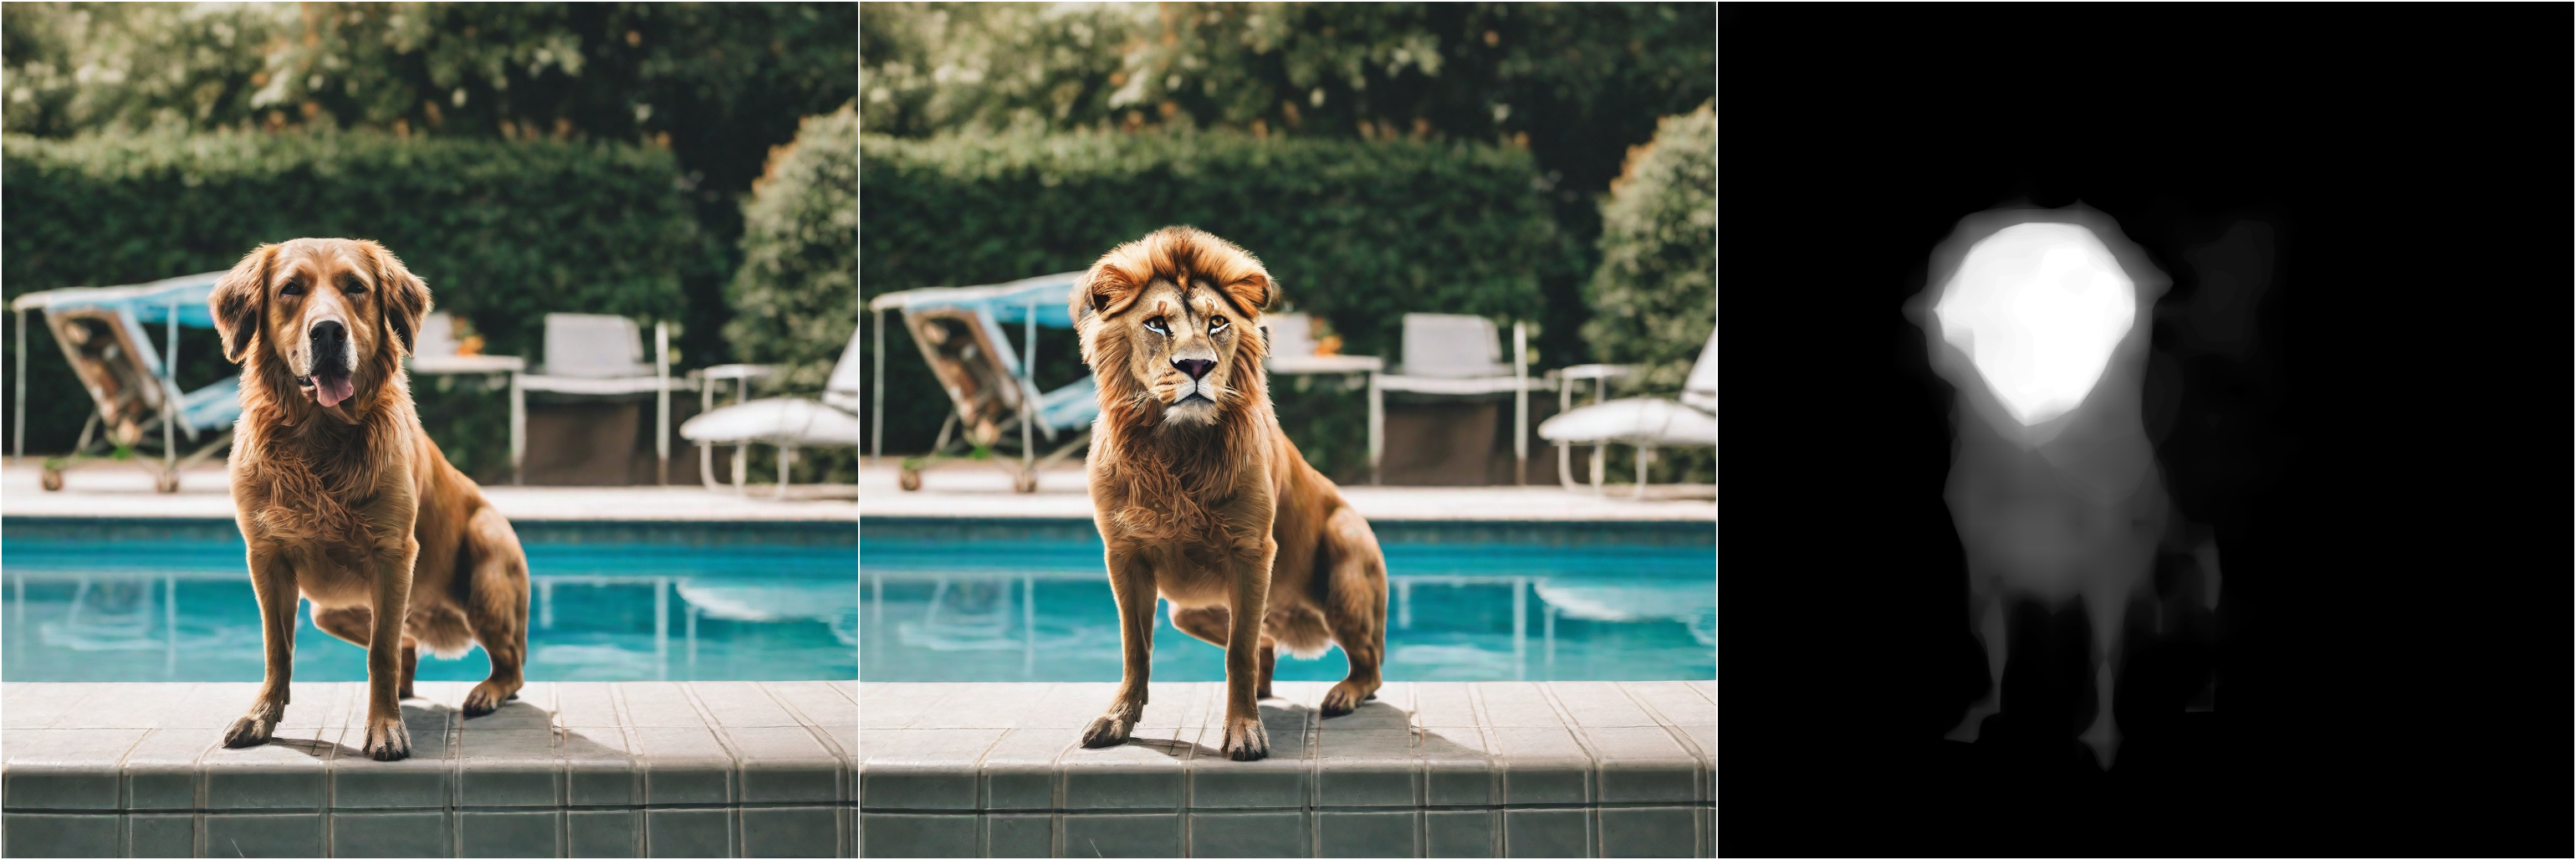

In [ ]:
seed = row['seed']
subject = row['subject']
prompt = row['prompt_original']
edit = row['edit']
prompts = [
    prompt,
    prompt.replace(subject, edit), # edit to cat
]
cross_attention_kwargs = {
        "edit_type": "replace", 
        "n_self_replace": 0.0, # for P2P set to 0.4
        # n_cross_replace should be set to 0.4 for comparable results to P2P
        # but can experiment with 0.0 with pure cross attention edit
        "n_cross_replace": {"default_": 1.0, subject: 0.4}, 
    }
extra_params = DotDictExtra()
# Example how to update params
extra_params.update({
    "omega": 1.5, # default already 1.5
    "index_inside_batch":[1], # "index_inside_batch":[1, 3] for multiple
    "batch_index": 2,
})

embedding_opt_k = PART_TOKENS.get(row['token_cls'])

image = pipe(
    prompts,
    num_inference_steps=50,
    eta=0.0,
    cross_attention_kwargs=cross_attention_kwargs,
    guidance_scale=7.5,
    generator=torch.Generator().manual_seed(seed),
    embedding_opt=embedding_opt_k,
    extra_kwargs=extra_params, # None also constructs default one
)

grid_tensor = make_grid([
    ToTensor()(image.images[0]), 
    ToTensor()(image.images[1]), 
    ToTensor()(pipe.final_map.convert('RGB'))
    ],
    padding=2,
    pad_value=1)
img = ToPILImage()(grid_tensor)
img